In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
from torch.optim import Adam
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_df=pd.read_csv('sign_mnist_train.csv')
test_df=pd.read_csv('sign_mnist_test.csv')
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [ ]:
train_label = train_df["label"]
train_data = train_df.drop(['label'], axis=1) / 255
test_label =  test_df["label"]
test_data = test_df.drop(['label'], axis=1) / 255

In [ ]:
class MyDataset(Dataset):

    def __init__(self, data, label):

        self.data = torch.tensor(data.values.reshape(-1, 1, 28, 28), dtype=torch.float32).to(device)
        self.label = torch.tensor(label.values.reshape(-1, 1)).to(device)

    def __len__(self):

        return len(self.data)

    def __getitem__(self, index):

        return self.data[index], self.label[index]


traindata = MyDataset(train_data, train_label)
testdata = MyDataset(test_data, test_label)

traindataloader = DataLoader(traindata, batch_size=64, shuffle=True)
testdataloader = DataLoader(testdata, shuffle=True)

In [ ]:
class CNN(nn.Module):
    def __init__(self, channel, num_classes):
        super(CNN, self).__init__()
        self.seq1 = nn.Sequential(
            nn.BatchNorm2d(channel),
            nn.Conv2d(channel, channel * 10, 3),
            nn.ReLU(), # (-1, 10, 26, 26)

            nn.BatchNorm2d(channel * 10),
            nn.Conv2d(channel * 10,  channel * 20, 3),
            nn.ReLU(),
            nn.MaxPool2d(2), # (-1, 20, 12, 12)

            nn.BatchNorm2d(channel * 20),
            nn.Conv2d(channel * 20,  channel * 40, 3),
            nn.ReLU(),
            nn.MaxPool2d(2), # (-1, 40, 5, 5)
        )

        self.seq2 = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(40 * 5 * 5, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.seq1(x)
        x = x.view(-1, 40 * 5 * 5)
        x = self.seq2(x)
        return x

In [ ]:
num_classes = train_label.max()
num_classes

24

In [ ]:
model = CNN(1, num_classes + 1)
model.to(device)
print(model)

CNN(
  (seq1): Sequential(
    (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU()
    (3): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (seq2): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=1000, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.3, inplace=False)
    (7): Linear

In [ ]:
optimizer = Adam(params=model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()
num_epochs = 20

In [ ]:
losses = []
loop = tqdm(range(num_epochs))
for epoch in loop:
    model.train()
    for data, label in traindataloader:
        outputs = model(data)
        loss = loss_func(outputs, label.squeeze(dim=1))
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 20/20 [00:27<00:00,  1.36s/it]


In [ ]:
losses[-1]

0.05926711484789848

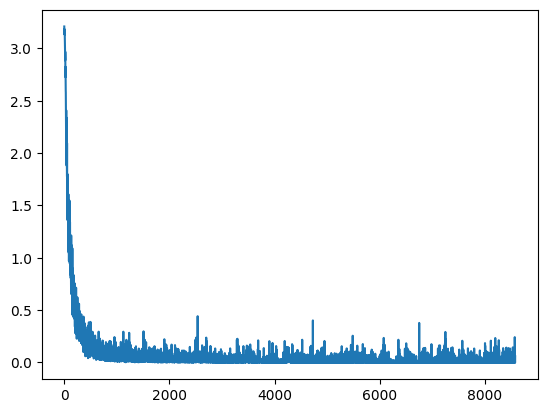

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)

real value =  21
predicted value =  21


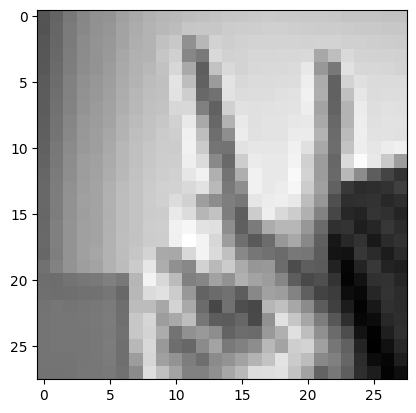

In [ ]:
img, label = next(iter(testdataloader))
print("real value = ", label.cpu().detach().numpy().squeeze())
print("predicted value = ", model(img).argmax().cpu().detach().numpy())
plt.imshow(img.cpu().detach().numpy().squeeze(), cmap = "gray")

In [ ]:
correct = 0
total = len(testdataloader)
for data, label in testdataloader:
    output = model(data).argmax().cpu().detach().numpy()
    if (output == label.squeeze().cpu().detach().numpy()):
        correct += 1
print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 92 %
